In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pytz
import sklearn
import scipy

from sklearn.model_selection import train_test_split

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import umap
import hdbscan

In [2]:
import warnings

# Suppress future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
   
# Suppress SettingWithCopyWarning


In [3]:
data = pd.read_csv('CPS.csv')

In [4]:
# Replace NaN values with -1
data.fillna(-1, inplace=True)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126784 entries, 0 to 126783
Columns: 389 entries, hrhhid2 to gtindvpc
dtypes: float64(342), int64(47)
memory usage: 376.3 MB


In [6]:
# Calculate the correlation matrix
correlation_matrix = data.corr()

In [7]:
# Set a high correlation threshold
high_corr_threshold = 0.98

# Find features with correlation greater than 0.98 or less than -0.98
highly_corr_vars = set()
for col in correlation_matrix.columns:
    for row in correlation_matrix.index:
        if (correlation_matrix.loc[row, col] > high_corr_threshold or correlation_matrix.loc[row, col] < -high_corr_threshold) and row != col:
            highly_corr_vars.add(tuple(sorted((row, col))))

# Remove one of each pair 
columns_to_remove = set()
for var1, var2 in highly_corr_vars:
    # Add one of the pair to the set to be removed
    columns_to_remove.add(var1) 

# Drop the columns from the dataframe
data_reduced = data.drop(columns=columns_to_remove)

In [8]:
data_reduced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126784 entries, 0 to 126783
Columns: 341 entries, hrhhid2 to gtindvpc
dtypes: float64(294), int64(47)
memory usage: 329.8 MB


In [9]:
# Calculate the percentage of -1 in each column
perc_na = (data_reduced == -1).mean()

# Identify columns where more than 40% of the data is -1
columns_to_drop = perc_na[perc_na > 0.4].index

# Drop these columns from the dataframe in place
data_reduced.drop(columns=columns_to_drop, inplace=True)

In [10]:
# Counting the number of columns using shape
data_reduced.shape[1]


106

In [11]:
# iterates over each column, converts float to categorical, and integer from int64 to int32 to save memory

for col in data_reduced.columns:
    if data_reduced[col].dtype == 'float64':
        data_reduced[col] = data_reduced[col].astype('category')
    elif data_reduced[col].dtype == 'int64':
        data_reduced[col] = data_reduced[col].astype('int32')


In [12]:
# Define the preprocessing for numeric and categorical data
numeric_features = data_reduced.select_dtypes(include=['int32', 'float64']).columns.tolist()
categorical_features = data_reduced.select_dtypes(include=['category']).columns.tolist()

# Preprocessor for transforming data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

#  Preprocess the data
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])
data_transformed = pipeline.fit_transform(data_reduced)

In [13]:
data_transformed.shape

(126784, 200772)

In [19]:
# Reduce dimensions with UMAP
reducer = umap.UMAP(n_neighbors=50, n_components=7, min_dist=0.0)
embedding = reducer.fit_transform(data_transformed)


C:\Users\almas\anaconda3\envs\myenv\lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


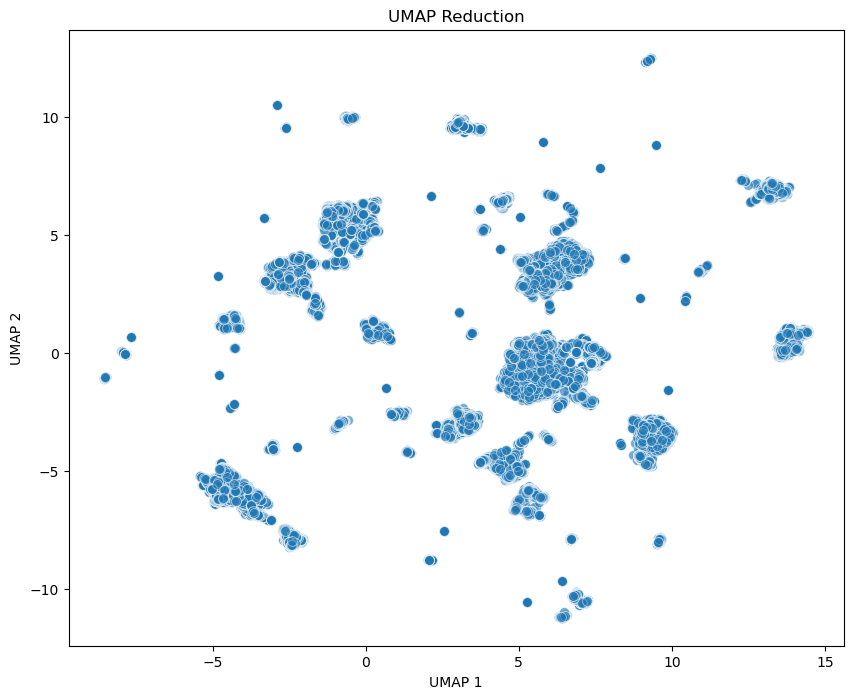

In [20]:
# Visualize the embedding
plt.figure(figsize=(10, 8))
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], s=50, alpha=0.6, legend='full')
plt.title('UMAP Reduction')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

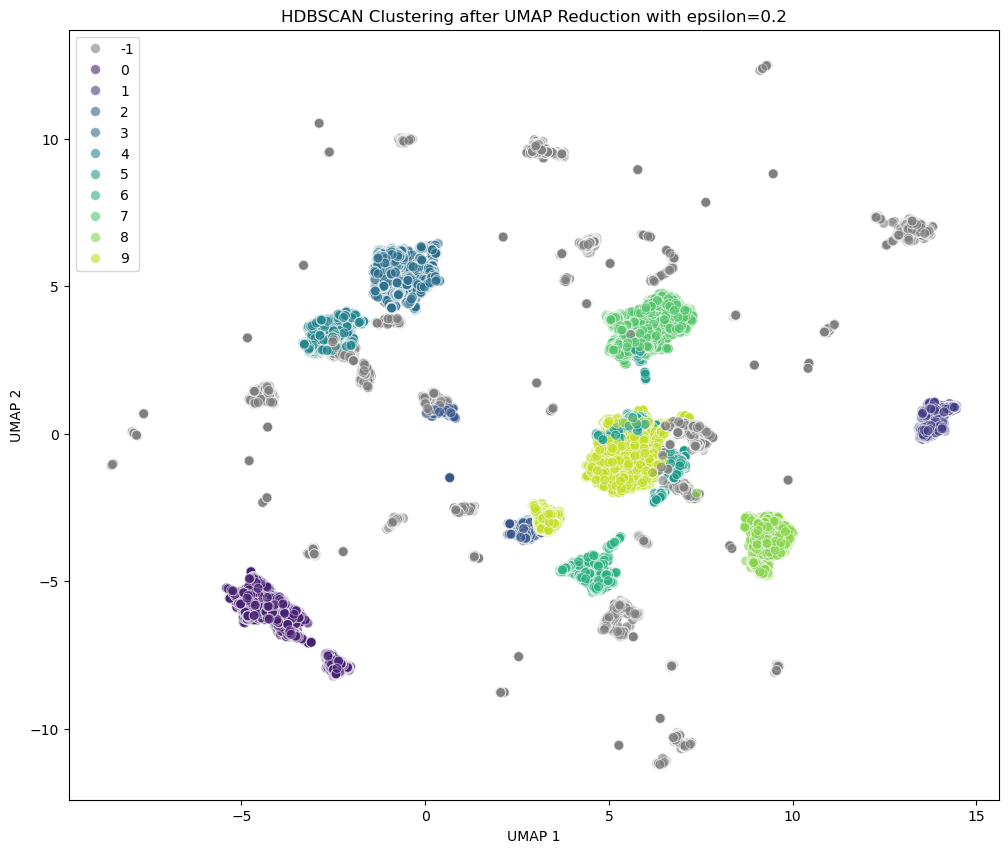

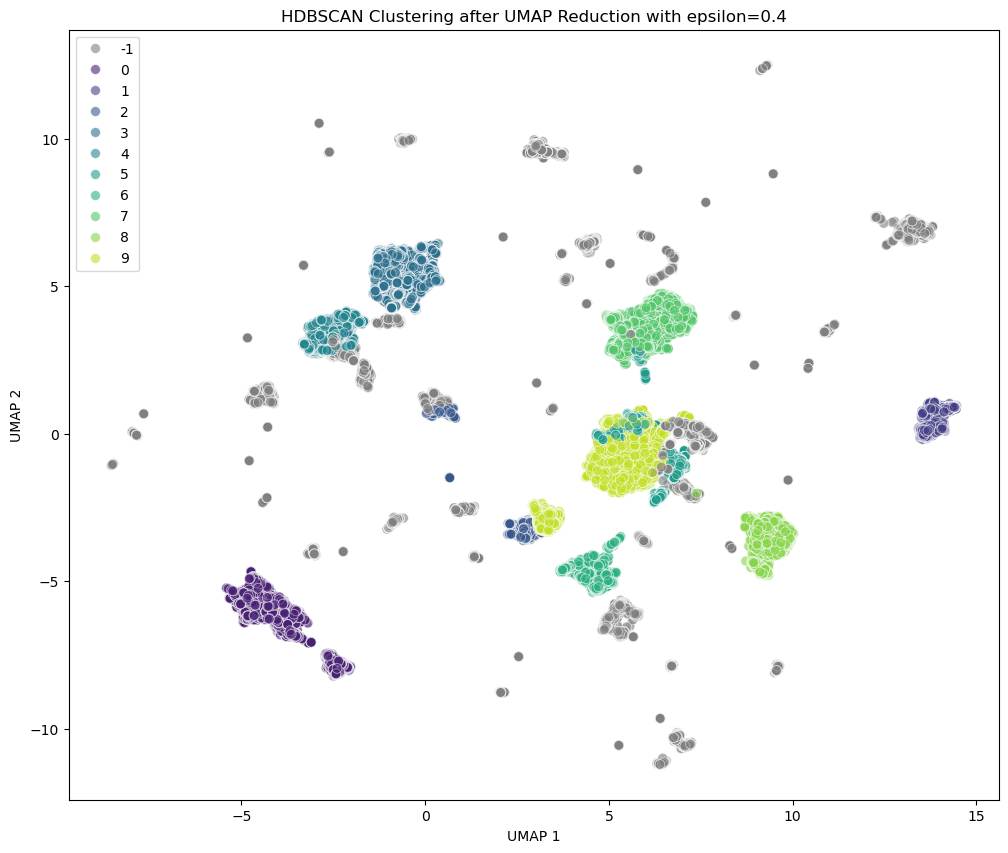

In [25]:
for epsilon in [0.2, 0.4]:  # Exploring different epsilon values
    clusterer = hdbscan.HDBSCAN(min_cluster_size=4000, min_samples=3000, cluster_selection_epsilon=epsilon)
    cluster_labels = clusterer.fit_predict(embedding)
    # Creating a custom palette:
    # Set the color for noise points (-1) as grey, and use 'viridis' for all other valid clusters
    unique_labels = np.unique(cluster_labels)
    colors = sns.color_palette('viridis', n_colors=len(unique_labels) - (1 if -1 in unique_labels else 0))
    palette = {label: colors.pop(0) for label in unique_labels if label != -1}
    palette[-1] = 'grey'  # Assign grey to noise points

    plt.figure(figsize=(12, 10))

    # Create a scatter plot. 'c' is used for coloring based on labels.
    sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=cluster_labels, palette=palette, s=50, alpha=0.6)
    
    # Add a colorbar to the plot
    
    # Add titles and labels
    plt.title(f'HDBSCAN Clustering after UMAP Reduction with epsilon={epsilon}')
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    
    # Show the plot
    plt.show()

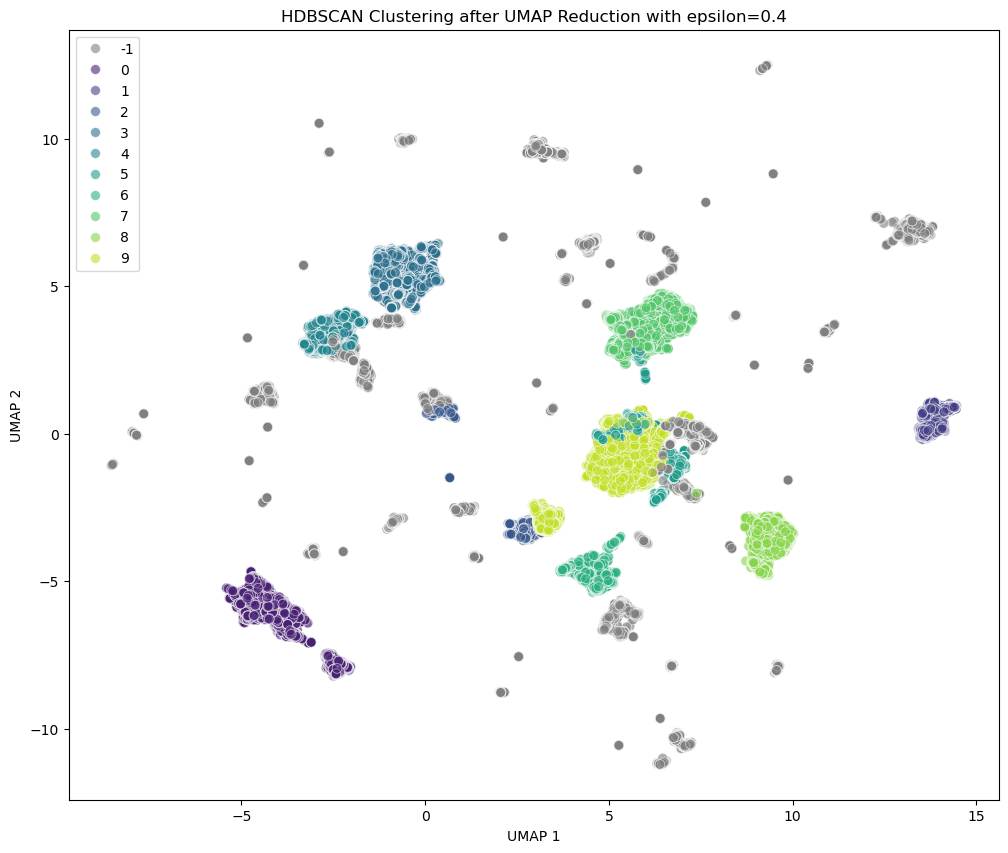

In [54]:
    plt.figure(figsize=(12, 10))

    # Create a scatter plot. 'c' is used for coloring based on labels.
    sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=cluster_labels, palette=palette, s=50, alpha=0.6)
    
    # Add a colorbar to the plot
    
    # Add titles and labels
    plt.title(f'HDBSCAN Clustering after UMAP Reduction with epsilon={epsilon}')
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    plt.savefig('AllClusters.png')
    # Show the plot
    plt.show()

In [26]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=4000, min_samples=3000, cluster_selection_epsilon=0.3)
cluster_labels = clusterer.fit_predict(embedding)

C:\Users\almas\AppData\Local\Temp\ipykernel_8740\1577411762.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = plt.cm.get_cmap('viridis', len(unique_labels) - (1 if -1 in unique_labels else 0))


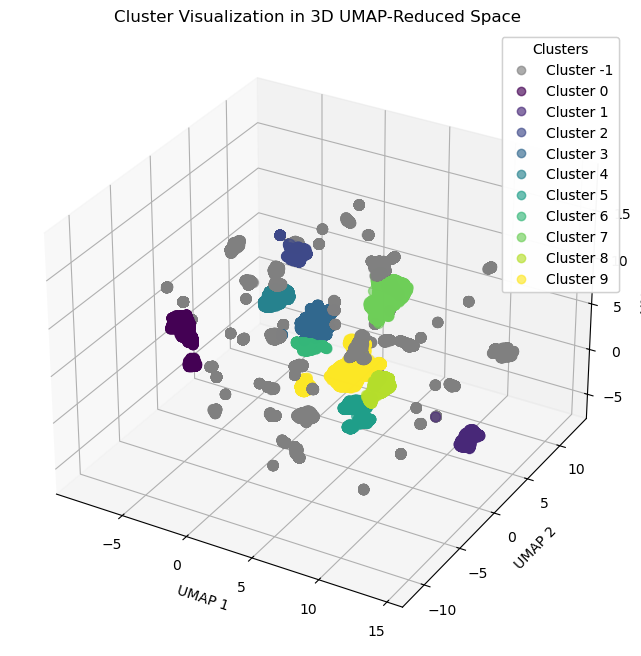

In [29]:
from matplotlib.colors import ListedColormap, Normalize


fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Custom colormap setup
unique_labels = np.unique(cluster_labels)
viridis = plt.cm.get_cmap('viridis', len(unique_labels) - (1 if -1 in unique_labels else 0))
colors = [viridis(i) for i in range(viridis.N)]
if -1 in unique_labels:
    colors = ['grey'] + colors  # prepend grey for noise
custom_cmap = ListedColormap(colors)

# Scatter plot with custom colormap
scatter = ax.scatter(embedding[:, 0], embedding[:, 1], embedding[:, 2], c=cluster_labels, cmap=custom_cmap, s=50, alpha=0.6)

ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')
ax.set_zlabel('UMAP 3')
plt.title('Cluster Visualization in 3D UMAP-Reduced Space')

# Create a custom legend
handles, labels = scatter.legend_elements(prop="colors", alpha=0.6)
labels = [f'Cluster {label}' if label != '-1' else 'Noise' for label in unique_labels]
legend = ax.legend(handles, labels, title="Clusters")

ax.add_artist(legend)
plt.show()


<Axes: ylabel='$\\lambda$ value'>

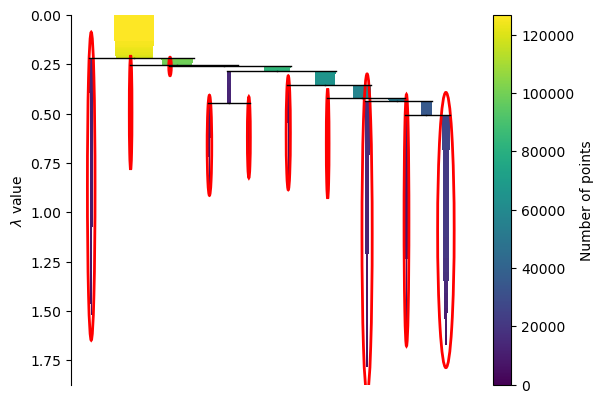

In [30]:
clusterer.condensed_tree_.plot(select_clusters=True,
                               selection_palette=sns.color_palette('deep', 8))

In [31]:
clusterer.condensed_tree_.to_networkx()

In [32]:
g = clusterer.condensed_tree_.to_networkx()
g.number_of_nodes()

126803

In [33]:
clusterer.condensed_tree_.to_pandas().head()

,parent,child,lambda_val,child_size
0,126784,79968,0.128688,1
1,126784,79967,0.128751,1
2,126784,19120,0.128849,1
3,126784,19115,0.128874,1
4,126784,104738,0.128917,1


In [34]:
tree = clusterer.condensed_tree_.to_pandas()
cluster_tree = tree[tree.child_size > 1]

In [35]:
cluster_tree

,parent,child,lambda_val,child_size
8181,126784,126785,0.217631,12284
8182,126784,126786,0.217631,106319
22773,126786,126787,0.253129,4325
22774,126786,126788,0.253129,92431
30491,126788,126789,0.260825,4102
30492,126788,126790,0.260825,86634
45322,126790,126791,0.282325,14541
45323,126790,126792,0.282325,66927
49858,126791,126793,0.448859,7437
49859,126791,126794,0.448859,4837


In [36]:
from sklearn.metrics import silhouette_score

# Assume 'embedding' is the UMAP-reduced data and 'cluster_labels' are from HDBSCAN
# Note: It is crucial to exclude noise points (typically labeled as -1 in HDBSCAN)
filtered_labels = cluster_labels[cluster_labels != -1]
filtered_embedding = embedding[cluster_labels != -1]

# Calculate the silhouette score
score = silhouette_score(filtered_embedding, filtered_labels)
print('Silhouette Score: ', score)

Silhouette Score:  0.7206652


In [39]:
data_reduced['Cluster_Labels'] = cluster_labels

In [42]:
# Select and rename relevant columns for analysis out of the 356 original columns 
selected_columns = {
    # Household Information
    'HUFINAL': 'interview_outcome',
    'hrnumhou': 'household_members',  # Number of members in a household
    'hefaminc' : 'family_income',

    # Education and Certification Details
    'peschlvl': 'highest_level_of_school',  # Highest level of school 
    'peeduca': 'education_level',  # Highest level of education completed
    'peedegr': 'highest_degree_earned',  # Highest degree earned
    'petrain': 'received_job_training',  # Received job training past high school
    'pecert1': 'professional_certification1',  # Professional certification 1
    'pecert2': 'cert_issued_by_state_or_gov',  # Is certificate issued by the state or the federal government?
    'pecert3': 'is_cert_required',  # Is certification needed for the job?

    # Employment and Income Details
    'pemlr': 'employment_status',  # Employment status
    'prunedor': 'duration_of_unemployment',  # Duration of unemployment
    'hefaminc': 'family_income',  # Family income
    'primind1': 'primary_industry_code_job1',  # Primary industry code for job 1
    'peio1icd': 'industry_code_job1',  # Industry code for job 1
    'ptio1ocd': 'occupation_code_job1',  # Occupation code for job 1
    'primind2': 'primary_industry_code_job2',  # Primary industry code for job 2
    'peio2icd': 'industry_code_job2',  # Industry code for second job 
    'ptio2ocd': 'occupation_code_job2',  # Occupation code for job 2
    'puwk': 'did_work_last_week',  # Did the individual work last week
    
    # Earnings
    'pternh1c': 'earnings_first_job',  # Earnings from the first job
    'pthr': 'total_hours_worked',  # Total hours worked
    'pternwa': 'weekly_earnings',  # Weekly earnings

    # Demographic Variables
    'ptdtrace': 'race',  # Race
    'prtage': 'age', 
    'pesex': 'gender',  # Gender
    'prcitshp': 'citizenship_status',  # Citizenship status

     # Geographic Information
    'gestfips': 'state_code',  # State FIPS code
    

     # Work Arrangement and Preferences
    'pehruslt': 'usual_hours_worked',  # Usual hours worked per week
    'pewa': 'work_at_home',  # Ability or frequency of working from home
    'pewm': 'work_multiple_jobs',  # Working multiple+ jobs
    
   
     # Job Search and Unemployment Details
    'pruntype': 'reason_for_unemployment',  # Reason for unemployment
    'pulaydtx': 'weeks_looking_for_work',  # Weeks spent looking for work
    'pulkm1': 'primary_method_of_job_search',  # Primary method of job search
    'puhrck12': 'job_search_method',  # Job search method

     # Health and Disability
    'pedisabl': 'disability_status',  # Disability status
    'pehspnon': 'health_status_impacting_work',  # Health status impacting work
    
}

In [44]:
# Filter the dataset to keep only the selected columns, verifying they exist
data_reduced = data_reduced[[col for col in selected_columns if col in data_reduced.columns]].rename(columns=selected_columns)

In [48]:
data_reduced['Cluster_Labels'] = cluster_labels

# Exploring Clusters


In [49]:
vis_data = data_reduced.copy()

In [50]:
# Given employment labels for direct mapping from the codes to their descriptions
employment_labels = [
    'EMPLOYED-AT WORK',
    'EMPLOYED-ABSENT',
    'UNEMPLOYED-ON LAYOFF',
    'UNEMPLOYED-LOOKING',
    'NOT IN LABOR FORCE-RETIRED',
    'NOT IN LABOR FORCE-DISABLED',
    'NOT IN LABOR FORCE-OTHER'
]

# Mapping from employment status codes to their descriptions
employment_status_descriptions = {i+1: label for i, label in enumerate(employment_labels)}

# Applying the mapping to the 'employment_status' column
vis_data['Employment_Status_Description'] = vis_data['employment_status'].map(employment_status_descriptions)

# Counting occurrences for each employment status description
employment_status_description_counts = vis_data['Employment_Status_Description'].value_counts()

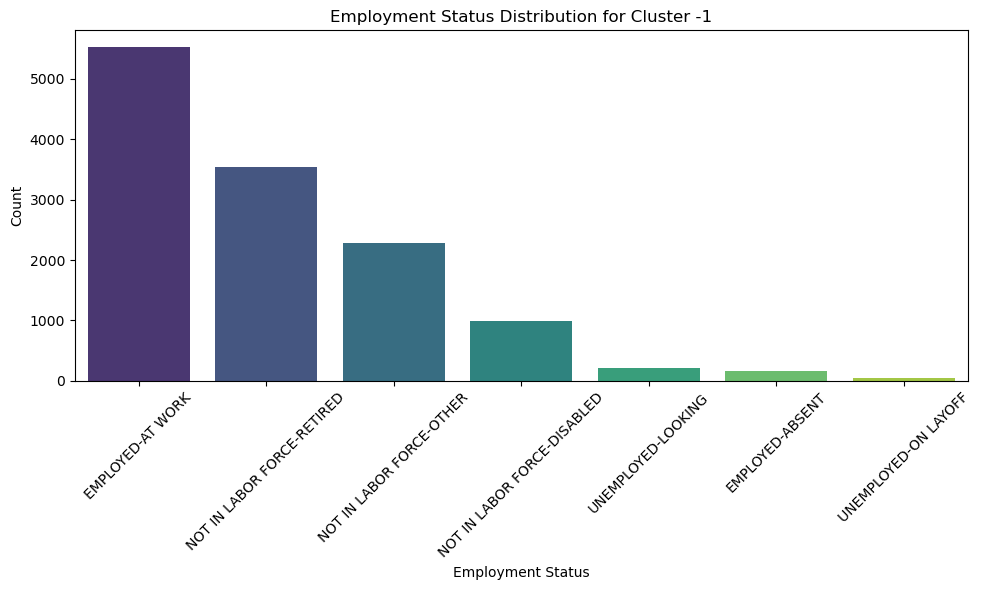

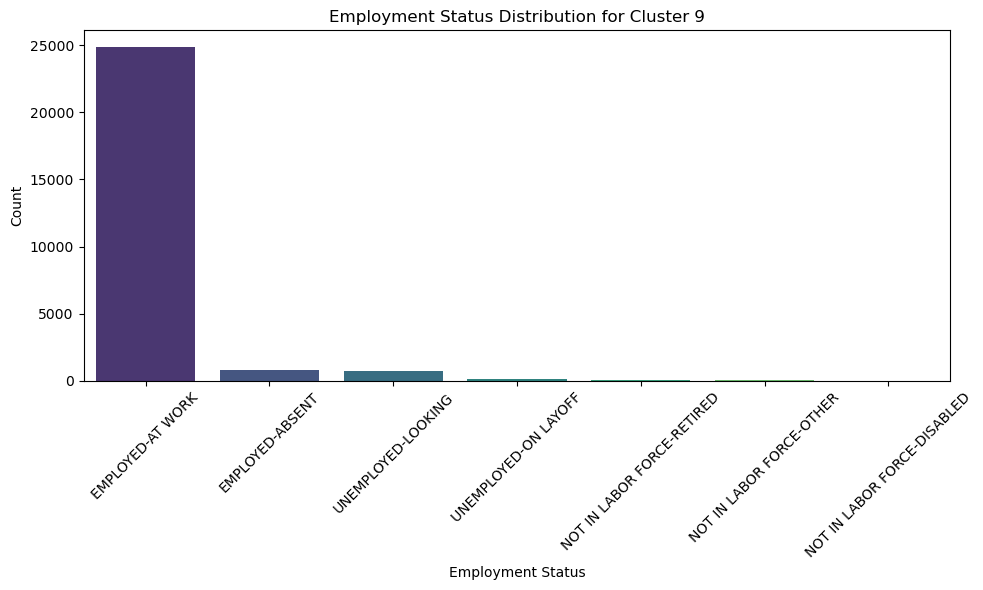

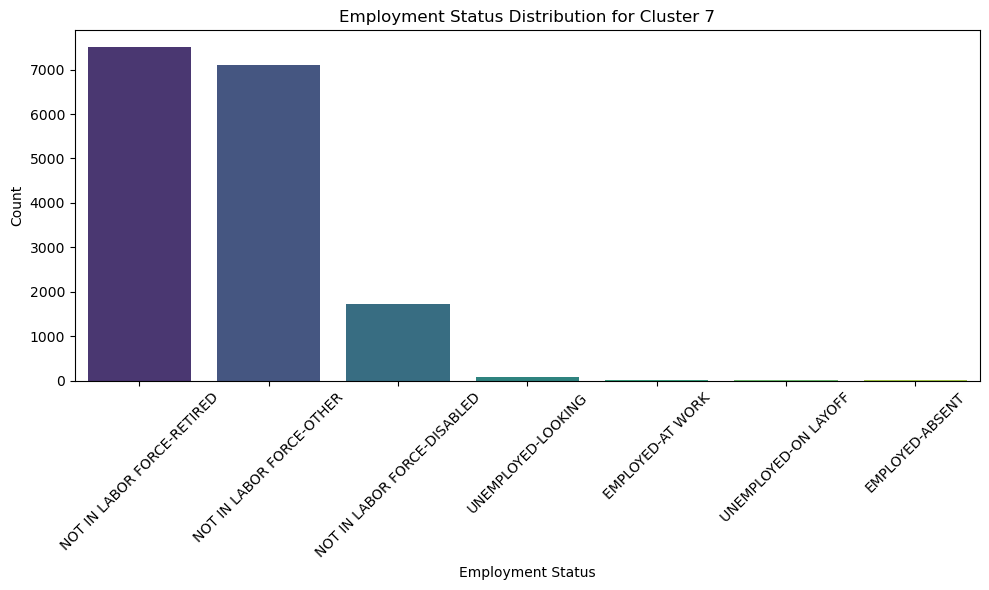

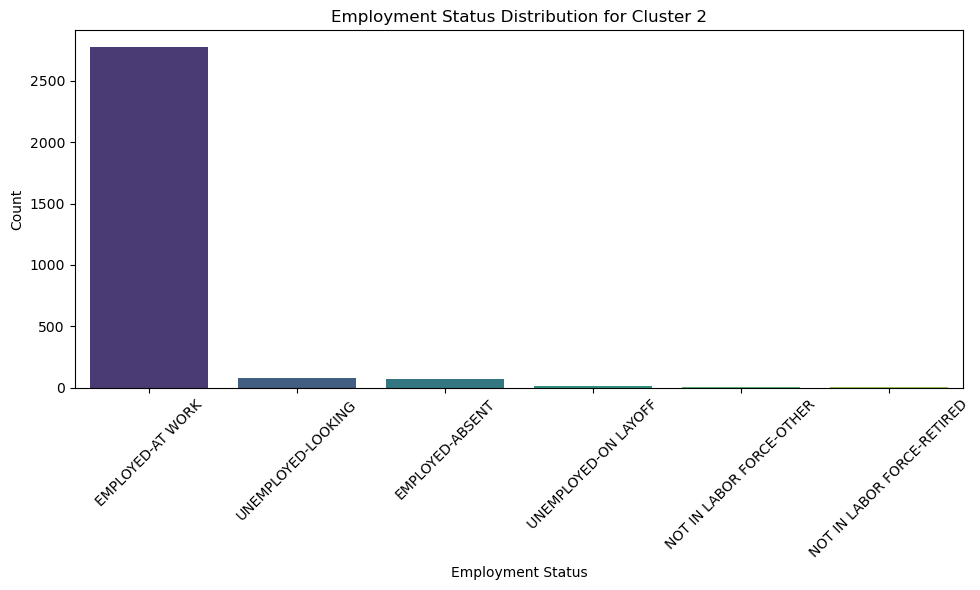

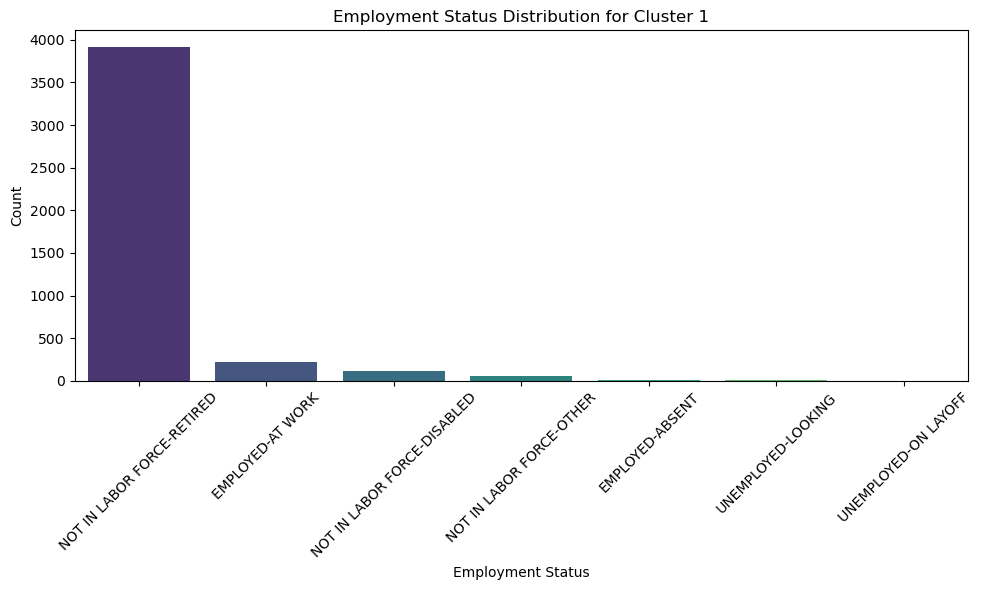

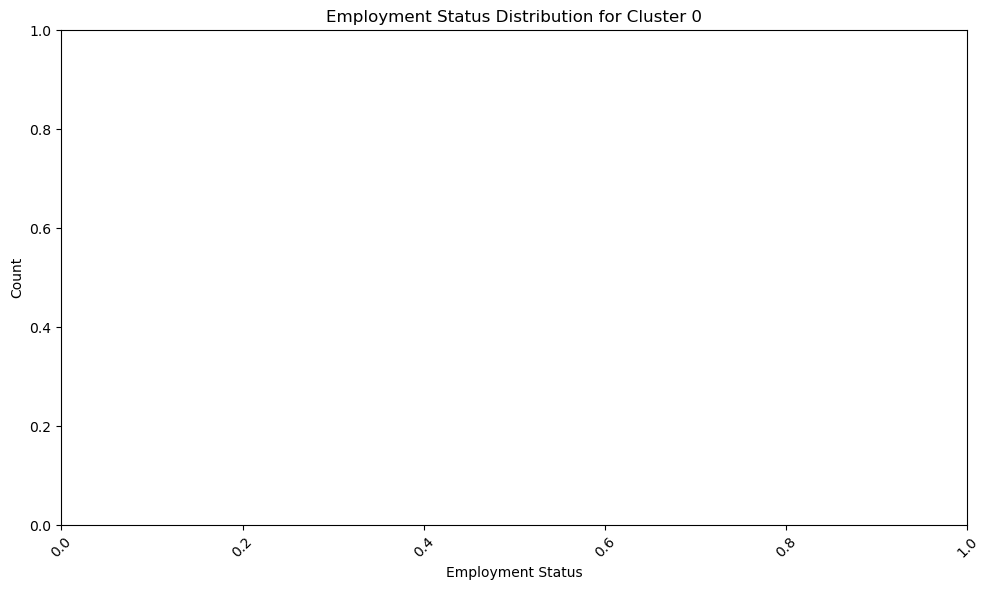

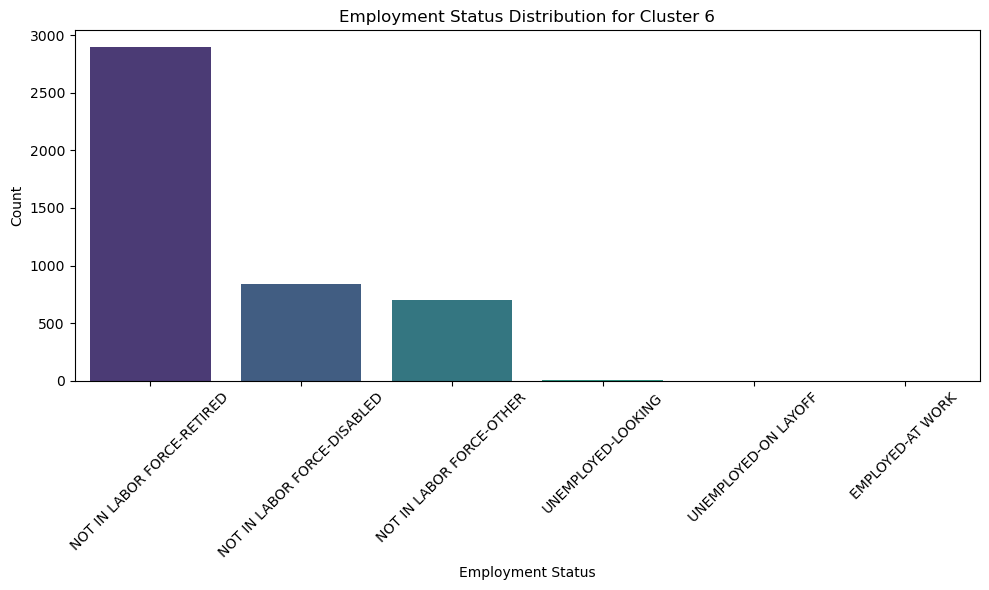

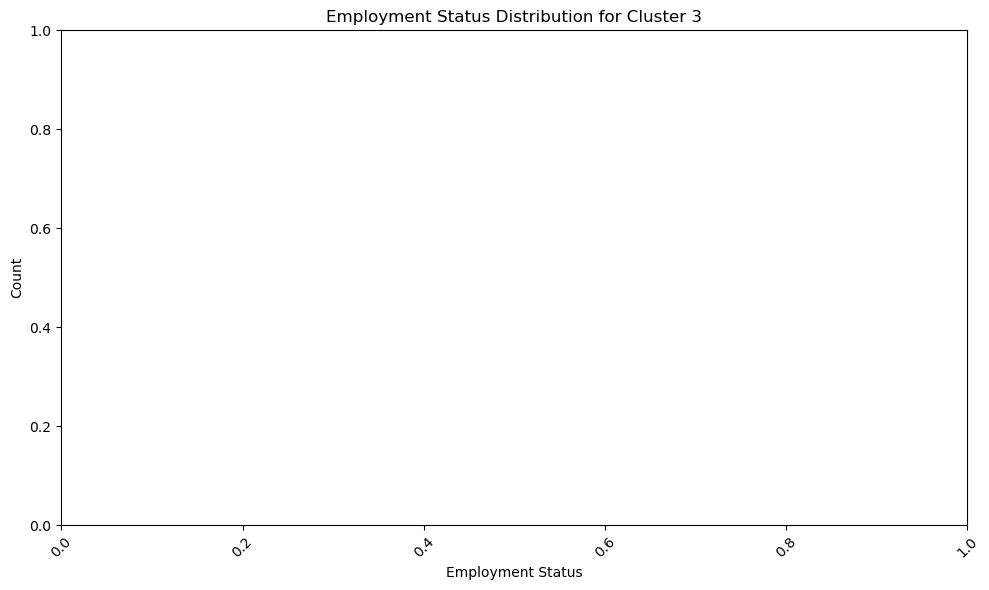

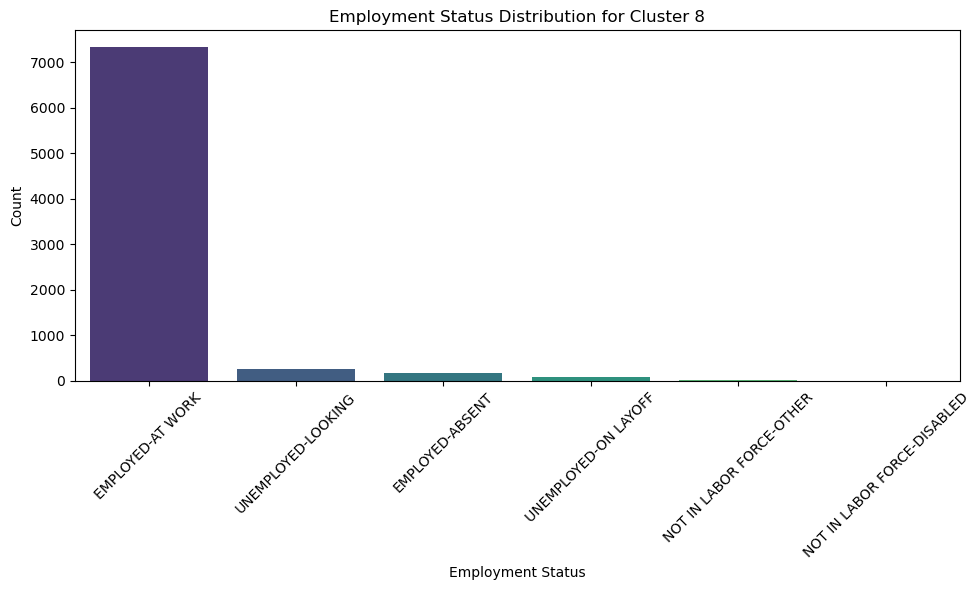

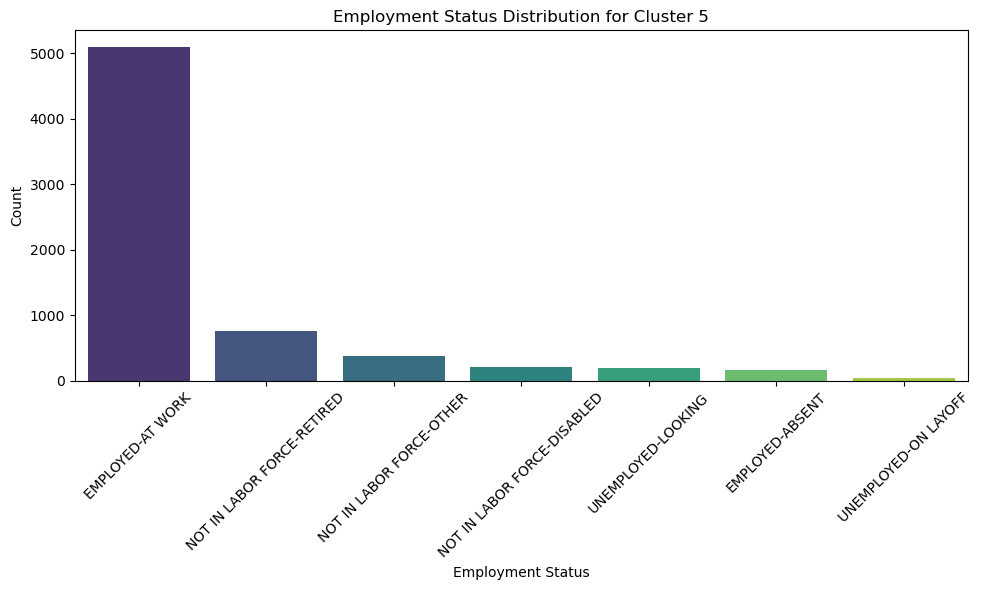

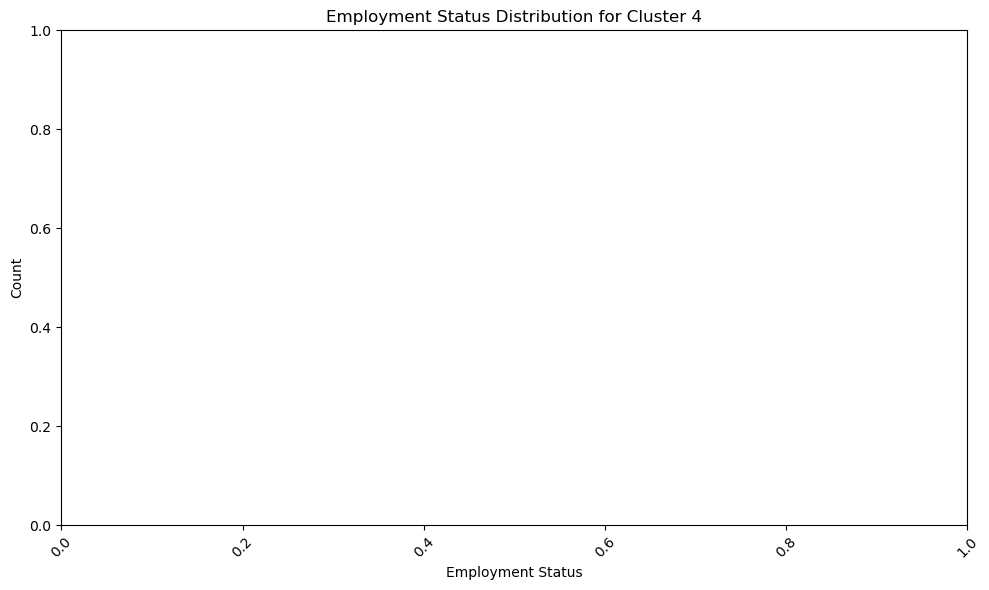

In [51]:
# Create a figure and axis for each unique cluster to visualize the counts of each employment status per cluster
clusters = data_reduced['Cluster_Labels'].unique()
for cluster in clusters:
    plt.figure(figsize=(10, 6))
    cluster_data = vis_data[vis_data['Cluster_Labels'] == cluster]
    employment_status_counts = cluster_data['Employment_Status_Description'].value_counts()
    
    sns.barplot(x=employment_status_counts.index, y=employment_status_counts.values, palette='viridis')
    plt.title(f'Employment Status Distribution for Cluster {cluster}')
    plt.xlabel('Employment Status')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'EMPstatusD_cluster_{cluster}.png')
    plt.show()